# README.md

This is the code for extension pt.3, "Patch-based Denoising in Frequency Domain" of our report, divided into several parts:


## **Frequency-Hybrid LIChI**
Contains the model class, utilities, and plotting functions

## **Run LIChI Extension and Generate Plots**
Main function calls. Runs the model and generates plots in the report.

## **Testing Noise Estimation Methods (DCT thresholding)**
A test model for the noise estimation methods.

## **Frequency-based Patch Matching**
Implementation of frequency domain patch matching. Can be integrated into LIChI. Very computationally expensive.




-Selina Li, 2025

Colab Utilities

In [ ]:
# Utilities for controlling GPU memory usage on Google Colab
# import os
# os.kill(os.getpid(), 9)
import gc
gc.collect()
torch.cuda.empty_cache()
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.ipc_collect()

## Frequency-Hybrid LIChI

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Name : LIChI
# Copyright (C) Inria,  Sébastien Herbreteau, Charles Kervrann, All Rights Reserved, 2022, v1.0.
import time
# import torch
import matplotlib.pyplot as plt

# from lichi import LIChI
from torchvision.io import read_image, write_png

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from skimage.restoration import estimate_sigma
from skimage.metrics import structural_similarity as ssim
import math
!pip install pywavelets
import pywt
!pip install torch-dct
import torch_dct as dct
!pip install brisque
import brisque
!pip install piq
import piq
import numpy as np
from scipy.ndimage import gaussian_laplace
import cv2


In [91]:
def estimate_noise(image):
    """ NEW
    Estimates noise using two methods:
    - Wavelet-based estimation from the high-high (HH) subband.
    - Laplacian-based estimation using a high-pass Gaussian Laplace filter.

    Args:
        image (torch.Tensor): Input image tensor (values in 0~255).

    Returns:
        tuple: (sigma, sigma2)
            sigma  - noise estimate from wavelet HH subband
            sigma2 - noise estimate from Gaussian Laplace filtering
    """
    if isinstance(image, torch.Tensor):
      image = image.cpu().numpy()
    coeffs = pywt.dwt2(image, 'db1')
    HH = coeffs[1][1]  # high-high subband
    sigma = np.median(np.abs(HH)) / 0.6745

    hp = gaussian_laplace(image.astype(np.float32), sigma=1.0)
    sigma2 = np.median(np.abs(hp)) / 0.6745

    return sigma,sigma2

class LIChI(nn.Module):
    """ A PyTorch module implementing LIChI denoising algorithm. """

    def __init__(self):
        """ Initializes the LIChI module and sets default parameters. """
        super(LIChI, self).__init__()
        self.set_parameters()

    def set_parameters(self, sigma=25.0, constraints='affine', method='n2n',
                        p1=11, p2=6, k1=16, k2=64, w=65, s=3, M=9, freq=False):
        """
        Sets the parameters for the denoising algorithm.

        Args:
            sigma (float): Standard deviation of the Gaussian noise.
            constraints (str): Type of constraints ('linear' or 'affine').
            method (str): Denoising method ('n2n', 'sure', 'avg', or 'noisy').
            p1 (int): Patch size for the first step.
            p2 (int): Patch size for the second step.
            k1 (int): Number of similar patches for the first step.
            k2 (int): Number of similar patches for the second step.
            w (int): Size of the search window (odd number).
            s (int): Moving step size from one reference patch to another
            M (int): Number of iterations.
        """
        for key, value in locals().items():
            if key != "self": setattr(self, key, value)

    @staticmethod
    def block_matching(input_x, k, p, w, s):
        """
        Finds similar patches within a specified window around each reference patch.

        Args:
            input_x (torch.Tensor): Input image tensor of shape (N, C, H, W).
            k (int): Number of most similar patches to find.
            p (int): Patch size.
            w (int): Search window size.
            s (int): Stride for moving between reference patches.

        Returns:
            torch.Tensor: Indices of similar patches for each reference patch.
        """

        def block_matching_aux(input_x_pad, k, p, v, s):
            """
            Auxiliary function to perform block matching in a padded input tensor.

            Args:
                input_x_pad (torch.Tensor): Padded input tensor.
                k (int): Number of similar patches to find.
                p (int): Patch size.
                v (int): Half of the search window size.
                s (int): Stride for moving between reference patches.

            Returns:
                torch.Tensor: Indices of similar patches for each reference patch.
            """
            N, C, H, W = input_x_pad.size()
            assert C == 1
            Href, Wref = -((H - (2*v+p) + 1) // -s), -((W - (2*v+p) + 1) // -s) # ceiling division, represents the number of reference patches along each axis for unfold with stride=s
            norm_patches = F.avg_pool2d(input_x_pad**2, p, stride=1)
            norm_patches = F.unfold(norm_patches, 2*v+1, stride=s)
            norm_patches = rearrange(norm_patches, 'n (p1 p2) l -> 1 (n l) p1 p2', p1=2*v+1)
            noise_patches = torch.zeros_like(norm_patches)
            local_windows = F.unfold(input_x_pad, 2*v+p, stride=s) / p
            local_windows = rearrange(local_windows, 'n (p1 p2) l -> 1 (n l) p1 p2', p1=2*v+p)
            ref_patches = rearrange(local_windows[..., v:-v, v:-v], '1 b p1 p2 -> b 1 p1 p2')
            scalar_product = F.conv2d(local_windows, ref_patches, groups=N*Href*Wref)
            distances = norm_patches - 2 * scalar_product # (up to a constant)
            distances[:, :, v, v] = float('-inf') # the reference patch is always taken
            distances = rearrange(distances, '1 (n h w) p1 p2 -> n h w (p1 p2)', n=N, h=Href, w=Wref)
            indices = torch.topk(distances, k, dim=3, largest=False, sorted=False).indices # float('nan') is considered to be the highest value for topk
            return indices

        v = w // 2
        input_x_pad = F.pad(input_x, [v]*4, mode='constant', value=float('nan'))
        N, C, H, W = input_x.size()
        Href, Wref = -((H - p + 1) // -s), -((W - p + 1) // -s) # ceiling division, represents the number of reference patches along each axis for unfold with stride=s
        ind_H_ref = torch.arange(0, H-p+1, step=s, device=input_x.device)
        ind_W_ref = torch.arange(0, W-p+1, step=s, device=input_x.device)
        if (H - p + 1) % s != 1:
            ind_H_ref = torch.cat((ind_H_ref, torch.tensor([H - p], device=input_x.device)), dim=0)
        if (W - p + 1) % s != 1:
            ind_W_ref = torch.cat((ind_W_ref, torch.tensor([W - p], device=input_x.device)), dim=0)

        indices = torch.empty(N, ind_H_ref.size(0), ind_W_ref.size(0), k, dtype=ind_H_ref.dtype, device=ind_H_ref.device)
        indices[:, :Href, :Wref, :] = block_matching_aux(input_x_pad, k, p, v, s)
        if (H - p + 1) % s != 1:
            indices[:, Href:, :Wref, :] = block_matching_aux(input_x_pad[:, :, -(2*v + p):, :], k, p, v, s)
        if (W - p + 1) % s != 1:
            indices[:, :Href, Wref:, :] = block_matching_aux(input_x_pad[:, :, :, -(2*v + p):], k, p, v, s)
            if (H - p + 1) % s != 1:
                indices[:, Href:, Wref:, :] = block_matching_aux(input_x_pad[:, :, -(2*v + p):, -(2*v + p):], k, p, v, s)

        # (ind_row, ind_col) is a 2d-representation of indices
        ind_row = torch.div(indices, 2*v+1, rounding_mode='floor') - v
        ind_col = torch.fmod(indices, 2*v+1) - v

        # from 2d to 1d representation of indices
        indices = (ind_row + rearrange(ind_H_ref, 'h -> 1 h 1 1')) * (W-p+1) + (ind_col + rearrange(ind_W_ref, 'w -> 1 1 w 1'))
        return rearrange(indices, 'n h w k -> n (h w k)', n=N)

    @staticmethod
    def gather_groups(input_y, indices, k, p):
        """
        Gathers groups of patches based on the indices from block matching.

        Args:
            input_y (torch.Tensor): Input image tensor of shape (N, C, H, W).
            indices (torch.Tensor): Indices of similar patches.
            k (int): Number of similar patches.
            p (int): Patch size.

        Returns:
            torch.Tensor: Grouped patches.
        """
        unfold_Y = F.unfold(input_y, p)
        N, n, l = unfold_Y.shape
        Y = torch.gather(unfold_Y, dim=2, index=repeat(indices, 'N l -> N n l', n=n))
        return rearrange(Y, 'N n (l k) -> N l k n', k=k)

    @staticmethod
    def aggregate(X_hat, weights, indices, H, W, p):
        """
        Aggregates groups of patches back into the image grid.

        Args:
            X_hat (torch.Tensor): Grouped denoised patches.
            weights (torch.Tensor): Weights of each patch.
            indices (torch.Tensor): Indices of the patches in the original image.
            H (int): Height of the original image.
            W (int): Width of the original image.
            p (int): Patch size.

        Returns:
            torch.Tensor: Reconstructed image tensor.
        """
        N, _, _, n = X_hat.size()
        X = rearrange(X_hat * weights, 'n l k p2 -> n p2 (l k)')
        weights = repeat(weights, 'N l k 1 -> N n (l k)', n=n)
        X_sum = torch.zeros(N, n, (H-p+1) * (W-p+1), dtype=X.dtype, device=X.device)
        weights_sum = torch.zeros_like(X_sum)

        for i in range(N):
            X_sum[i, :, :].index_add_(1, indices[i, :], X[i, :, :])
            weights_sum[i, :, :].index_add_(1, indices[i, :], weights[i, :, :])

        return F.fold(X_sum, (H, W), p) / F.fold(weights_sum, (H, W), p)

    def compute_theta(self, Q, D):
        """
        Computes the theta matrix based on the provided constraints.

        Args:
            Q (torch.Tensor): Q matrix, shape (N, B, k, k).
            D (torch.Tensor): Diagonal matrix, shape (1, 1, k).

        Returns:
            torch.Tensor: Theta matrix, shape (N, B, k, k).
        """
        N, B, k, _ = Q.size()
        if self.constraints == 'linear' or self.constraints == 'affine':
            Ik = torch.eye(k, dtype=Q.dtype, device=Q.device).expand(N, B, -1, -1)
            L = torch.linalg.cholesky(Q)
            Qinv = torch.cholesky_solve(Ik, L)
            if self.constraints == 'linear':
                theta = Ik - Qinv * D.unsqueeze(-1)
            else:
                Qinv1 = torch.sum(Qinv, dim=3, keepdim=True)
                Qinv2 = torch.sum(Qinv1, dim=2, keepdim=True)
                theta = Ik - (Qinv - Qinv1 @ Qinv1.transpose(2, 3) / Qinv2) * D.unsqueeze(-1)
        else:
            raise ValueError('constraints must be either linear, affine, conical or convex.')
        return theta.transpose(2,3)

    def denoise1(self, Y, sigma):
        """
        Denoises each group of similar patches (step 1).

        Args:
            Y (torch.Tensor): Grouped patches tensor, shape (N, B, k, n).
            sigma (float): Noise standard deviation.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                X_hat: Denoised patches, shape (N, B, k, n).
                weights: Patch weights, shape (N, B, k, 1).
        """
        N, B, k, n = Y.size()
        if self.method=='sure':
            D = n * sigma**2 * torch.ones(1, 1, k, dtype=Y.dtype, device=Y.device)
            Q = Y @ Y.transpose(2, 3)
            theta = self.compute_theta(Q, D)
        elif self.method=='n2n':
            alpha = 0.5
            D = n * sigma**2 * torch.ones(1, 1, k, dtype=Y.dtype, device=Y.device)
            E = n * alpha**2 * sigma**2 * torch.ones(1, 1, k, dtype=Y.dtype, device=Y.device)
            Q = Y @ Y.transpose(2, 3)
            theta = self.compute_theta(Q + torch.diag_embed(E), D + E)
        elif self.method=='avg':
            theta = torch.ones(N, B, k, k, dtype=Y.dtype, device=Y.device) / k
        elif self.method=='noisy':
            theta = torch.eye(k, dtype=Y.dtype, device=Y.device).expand(N, B, -1, -1)
        else:
            raise Exception('Method must be either sure, n2n, avg or noisy.')
        X_hat = theta @ Y
        weights = 1 / torch.sum(theta**2, dim=3, keepdim=True).clip(1/k, 1)
        return X_hat, weights

    def denoise2(self, Z, X, Y, sigma, tau):
        """
        Denoises each group of similar patches (step 2).

        Args:
            Z (torch.Tensor): Input noisy patches, shape (N, B, k, n).
              (torch.Tensor): Previous estimate of denoised patches, shape (N, B, k, n).
            Y (torch.Tensor): Original patches, shape (N, B, k, n).
            sigma (float): Noise standard deviation.
            tau (float): Tau parameter.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                X_hat: Refined estimate of denoised patches, shape (N, B, k, n).
                Z_hat: Updated patches with adaptive weighting, shape (N, B, k, n).
                weights: Patch weights, shape (N, B, k, 1).
        """
        N, B, k, n = Z.size()
        t = 1 - torch.std(Y - Z, dim=(2,3), keepdim=True, unbiased=False) / sigma
        t = t.clip(min=tau+1e-6)
        D = n * (sigma * t[:, :, :, 0].expand(-1, -1, k))**2
        Q = X @ X.transpose(2, 3) + torch.diag_embed(D)
        xi = self.compute_theta(Q, D)
        X_hat = xi @ Z
        Z_hat = (1 - tau/t) * X_hat + tau/t * Z
        weights = 1 / torch.sum(xi**2, dim=3, keepdim=True).clip(min=1/k)
        return X_hat, Z_hat, weights

    def step1(self, input_y, sigma):
        """
        Performs the first denoising step on the input image.

        Args:
            input_y (torch.Tensor): Noisy input image, shape (N, C, H, W).
            sigma (float): Noise standard deviation.

        Returns:
            torch.Tensor: First-stage denoised image, shape (N, C, H, W).
        """
        _, _, H, W = input_y.size()
        k, p, w, s = self.k1, self.p1, self.w, self.s
        y_mean = torch.mean(input_y, dim=1, keepdim=True) # for color
        indices = self.block_matching(y_mean, k, p, w, s)
        Y = self.gather_groups(input_y, indices, k, p)
        X_hat, weights = self.denoise1(Y, sigma)
        x_hat = self.aggregate(X_hat, weights, indices, H, W, p)
        if self.freq: x_hat = self.frequency_refinement(x_hat)
        return x_hat

    def step2(self, input_z, input_x, input_y, sigma, tau, indices=None):
        """
        Performs the second denoising step with refined patch estimates.

        Args:
            input_z (torch.Tensor): Previous noisy estimate, shape (N, C, H, W).
            input_x (torch.Tensor): Previous denoised estimate, shape (N, C, H, W).
            input_y (torch.Tensor): Original noisy input image, shape (N, C, H, W).
            sigma (float): Noise standard deviation.
            tau (float): Tau parameter.
            indices (torch.Tensor, optional): Patch indices, default is None.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                x_hat: Refined denoised image, shape (N, C, H, W).
                z_hat: Updated noisy estimate, shape (N, C, H, W).
                indices: Patch indices used, shape (N, L).
        """
        N, C, H, W = input_y.size()
        k, p, w, s = self.k2, self.p2, self.w, self.s
        z_block = torch.mean(input_z, dim=1, keepdim=True) # for color
        if indices is None: indices = self.block_matching(z_block, k, p, w, s)
        X = self.gather_groups(input_x, indices, k, p)
        Y = self.gather_groups(input_y, indices, k, p)
        Z = self.gather_groups(input_z, indices, k, p)
        X_hat, Z_hat, weights = self.denoise2(Z, X, Y, sigma, tau)
        x_hat = self.aggregate(X_hat, weights, indices, H, W, p)
        z_hat = self.aggregate(Z_hat, weights, indices, H, W, p)
        if self.freq: x_hat = self.frequency_refinement(x_hat)
        return x_hat, z_hat, indices

    def forward(self, y, sigma=25.0, constraints='affine', method='n2n',
                p1=11, p2=6, k1=16, k2=64, w=65, s=3, M=9,freq=False):
        """
        Executes the full denoising process on the input image.

        Args:
            y (torch.Tensor): Noisy input image, shape (N, C, H, W).
            sigma (float): Standard deviation of the Gaussian noise.
            constraints (str): Type of constraints ('linear' or 'affine').
            method (str): Denoising method ('n2n', 'sure', 'avg', or 'noisy').
            p1 (int): Patch size for the first step.
            p2 (int): Patch size for the second step.
            k1 (int): Number of similar patches for the first step.
            k2 (int): Number of similar patches for the second step.
            w (int): Size of the search window (odd number).
            s (int): Moving step size from one reference patch to another
            M (int): Number of iterations.

        Returns:
            torch.Tensor: Final denoised image, shape (N, C, H, W).
        """
        self.set_parameters(sigma, constraints, method, p1, p2, k1, k2, w, s, M,freq)
        z, x  = y, self.step1(y, sigma) # first pilot
        for m in range(self.M):
            tau = (1-(m+1)/self.M)*0.75
            if m%3==0:
                x, z, indices = self.step2(z, x, y, sigma, tau)
            else:
                x, z, indices = self.step2(z, x, y, sigma, tau, indices)
        # z=self.noise_estimate(z)
        return z

    def dct_denoise(self, x, sigma):
        """ NEW
        DCT thresholding denoising

        Args:
            x: Input tensor (any shape, will be converted to numpy)
            sigma: Noise standard deviation

        Returns:
            torch.Tensor: Denoised tensor (same shape as x)
        """
        # Normalize to [0, 1]
        if x.max() - x.min() < 1e-6 or torch.all(x == 0): return x
        x = torch.clamp(x / 255, 0.0, 1.0)

        xdct1 = dct.dct(x)
        xdct1_denoised = xdct1 * (xdct1.abs() > (sigma))
        x1 = dct.idct(xdct1_denoised)

        # xdct2=xdct1.clone()
        # xdct2_denoised = xdct2 * (xdct2.abs() > (sigmalaplace))
        # x2 = dct.idct(xdct2_denoised)
        # out = (x1+x2)/2

        out = torch.clamp(x1 * 255, 0, 255)
        return out

    def wavelet_denoise(self, x, sigma, wavelet='haar'):
        """ NEW
        Wavelet denoising

        Args:
            x: Input tensor (any shape, will be converted to numpy)
            sigma: Noise standard deviation
            wavelet: Wavelet type (default: 'haar')
        Returns:
            torch.Tensor: Denoised tensor (same shape as x)
        """
        # Convert to numpy and ensure 2D
        unsqueeze=False
        if x.ndim > 2:
            unsqueeze=True
            x = x.squeeze()

        orig_shape = x.shape[-2:]

        # Wavelet decomposition (level=2) pad to make divisible by 2^level
        pad_h = (4 - (x.shape[-2] % 4)) % 4
        pad_w = (4 - (x.shape[-1] % 4)) % 4
        x_padded = F.pad(x, (0, pad_w, 0, pad_h))

        # Wavelet transform
        coeffs = pywt.wavedec2(x_padded.cpu().numpy(), wavelet, level=2)
        coeffs_thresh = [coeffs[0]] + [
            tuple(pywt.threshold(c, sigma, mode='soft') for c in det)
            for det in coeffs[1:]
        ]

        # Reconstruct and crop
        denoised = pywt.waverec2(coeffs_thresh, wavelet)
        denoised = denoised[:orig_shape[0], :orig_shape[1]]

        denoised=torch.from_numpy(denoised).to(x.device)
        if unsqueeze:
          denoised=denoised.unsqueeze(0)
        return denoised

    def frequency_refinement(self, x):
        """ NEW
        Applies frequency-domain denoising
        Uses gradient to compute 'edgeness', then apply wavelet denoising to
        edge regions and DCT denoising to flat regions

        Noise level (sigma) is stimated from the input image.

        Blends denoised image with original input.

        Args:
            x: Input image tensor (values in 0~255)

        Returns:
            torch.Tensor: Denoised tensor (same shape as x)
        """
        # Detect edges
        grad_thresh=0.1
        gx,gy=torch.gradient(x, dim=(-2, -1))
        grad = torch.abs(gx**2+gy**2).sum(dim=0)
        mask = (grad > grad_thresh * grad.max())

        # Use the larger estimated noise
        sigmas = estimate_noise(x)
        sigma=np.min(sigmas)

        # Denoise edges with wavelets and flat regions with DCT
        x_dct = self.dct_denoise(x,torch.tensor(3*sigma))
        x_wavelet = self.wavelet_denoise(x,3*sigma)
        out = torch.where(mask, x_wavelet, x_dct)#
        # print(out.shape)

        # # Adaptive blending (reduce alpha for low-noise patches)
        # alpha = sigma**2 / (sigma**2 + 0.01)
        # alpha = torch.tensor(alpha)
        # x = (1 - alpha) * x + alpha * out

        # Blending (Can be adjusted)
        out = out * .9 + x * .1
        out = torch.clamp(out * 255, 0, 255)
        return out


In [80]:
def lichiext(img_noisy, sigma, freq):
  """
  Call extended LIChI with different settings based on noise level

  Args:
    img_noisy: 4D tensor intput. RGB channels are fine.
    sigma: noise level estimation for LIChI
    freq: Whether to use the frequency extensions, True/False.
  """
  with torch.no_grad():
      model = LIChI()
      model.eval()
      method='n2n'
      freq=freq
      if sigma <= 10:
          img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method=method, p1=9, p2=6, k1=16, k2=64, w=65, s=3, M=6,freq=freq)
      elif sigma <= 30:
          img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method=method, p1=11, p2=6, k1=16, k2=64, w=65, s=3, M=9,freq=freq)
      else:
          img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method=method, p1=13, p2=6, k1=16, k2=64, w=65, s=3, M=11,freq=freq)
      img_lichi = img_lichi.clip(0, 255)
      return img_lichi

def call_loop(sigma,noisy_image):
    """
    Run LIChI with estimated noise = sigma.
    """
    try:
      # To avoid breaking PSD in the Bayesian estimation, noise level has to be
      # sufficiently high. The loop guarantees we find a proper noise level from
      # the initial estimates.
      start = time.time()
      denoised=lichiext(noisy_image,sigma=sigma,freq=False)[0,0].to("cpu").numpy()
      end = time.time()
      elapsed=end - start

      start = time.time()
      denoised_freq=lichiext(noisy_image,sigma=sigma,freq=True)[0,0].to("cpu").numpy()
      end = time.time()
      elapsed_freq=end - start

      return True,[denoised,denoised_freq,elapsed,elapsed_freq]
    except Exception as e:
      print(e)
      return False,[]

def main(path_in,added_noise,noise_est_start=0,structured=False):
  """
  Main

  Args:
    path_in: Path to the input image.
    added_noise: Noise level sigma.
    noise_est_start: Estimated minimum noise level (sigma).
  Returns:
    img: Original image
    noisy_image: Noisy image
    denoised etc:
      Denoised images (with/without extension) and respective elapsed time
  """
  img = read_image(path_in)[None,:,:,:].float().mean(dim=1,keepdim=True).to(device)
  sigma = torch.tensor(added_noise)
  if not structured:
    noise_tensor = torch.rand(img.shape) * sigma
  else:
    noise_tensor = torch.tensor(structured_gaussian_noise(img.shape)) * sigma
  noisy_image = img + noise_tensor.to(device)
  noisy_image = (noisy_image-noisy_image.min()) / (noisy_image.max()-noisy_image.min()) * 255
  with torch.no_grad():
    sigma_est, sigma_est_laplace = estimate_noise(noisy_image)
    sigma_est+=noise_est_start
    sucess=False
    while not sucess:
      sucess,vals=call_loop(sigma_est,noisy_image)
      sigma_est+=1
    denoised,denoised_freq,elapsed,elapsed_freq=vals
    print(sigma_est)
    return added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq

In [33]:
def plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq):
  fig,axs=plt.subplots(1,5,figsize=(30//2,12//2))

  from brisque import BRISQUE
  obj = BRISQUE(url=False)

  noisy_image_disp=noisy_image[0,0].to("cpu").numpy()
  img_disp=img[0,0].to("cpu").numpy()

  imgs = [img_disp,noisy_image_disp,denoised,denoised_freq,denoised_freq-denoised]
  titles = ["Original","Noisy","Denoised1 (LIChI)","Denoised2 (LIChI + DCT-Wavelet)","Difference 1-2"]
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]
  brisques = [obj.score(np.stack([x]*3, axis=-1)) for x in imgs]
  ssims = [ssim(img_disp, x,data_range=255) for x in imgs]

  for i in range(len(imgs)):
      axs[i].imshow(imgs[i],cmap='gray')
      axs[i].set_aspect(1.1)
      axs[i].set_title(titles[i])
      if psnrs[i]==np.inf:
        psnr="inf"
      else:
        psnr=int(psnrs[i])
      if i!=len(imgs)-1:
        axs[i].set_xlabel(f"PSNR={psnr}, SSIM={round(ssims[i],2)}\nBRISQUE={round(brisques[i],2)}")
      else:
        axs[i].set_xlabel(f"LIChI runtime={round(elapsed,2)}\nLIChI_freq runtime={round(elapsed_freq,2)}")
      if i==0:
        axs[i].set_xlabel(f"Added noise: sigma={added_noise}\nBRISQUE={round(brisques[i],2)}")
  fig.tight_layout()

  # diff=np.linalg.norm(denoised_freq-noisy_image_disp)
  # axs[1].set_xlabel(f"norm difference from noisy = {int(diff)}")
  # axs[2].set_xlabel(f"norm difference from LIChI = {int(diff)}")

In [58]:
from scipy.ndimage import gaussian_filter

def structured_gaussian_noise(shape, std=1.0, smooth_sigma=2.0):
    noise = np.random.normal(0, std, size=shape)
    structured_noise = gaussian_filter(noise, sigma=smooth_sigma)
    return structured_noise

### Run LIChI Extension and Generate Plots

linalg.cholesky: (Batch element 24): The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).
linalg.cholesky: (Batch element 24): The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).
linalg.cholesky: (Batch element 24): The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).
linalg.cholesky: (Batch element 194): The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).
linalg.cholesky: (Batch element 194): The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).
linalg.cholesky: (Batch element 194): The factorization could not be completed because the input is not posi

<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


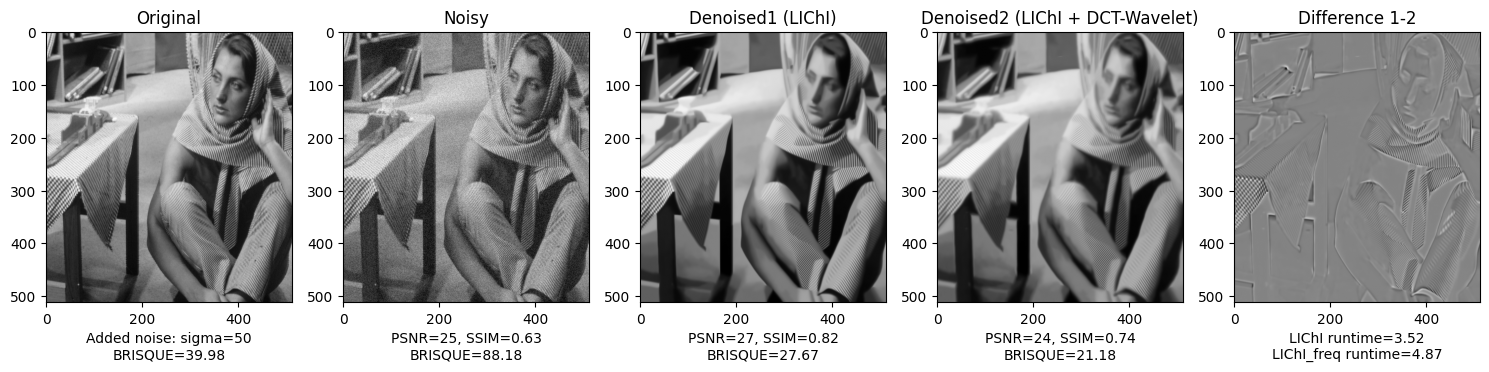

In [34]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./barbara.png', added_noise=50)
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

39.35329


<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


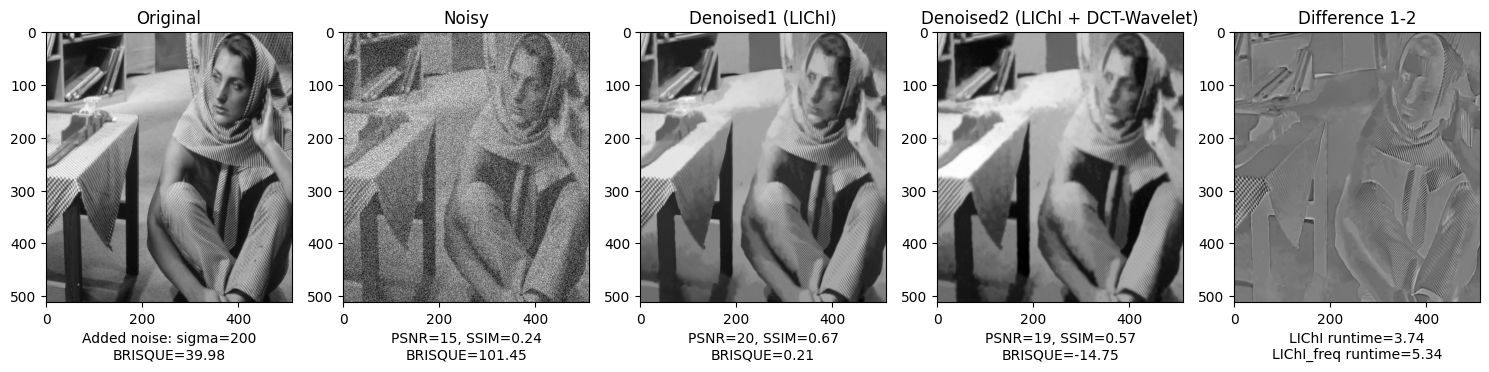

In [55]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./barbara.png', added_noise=200)
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

31.189053


<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


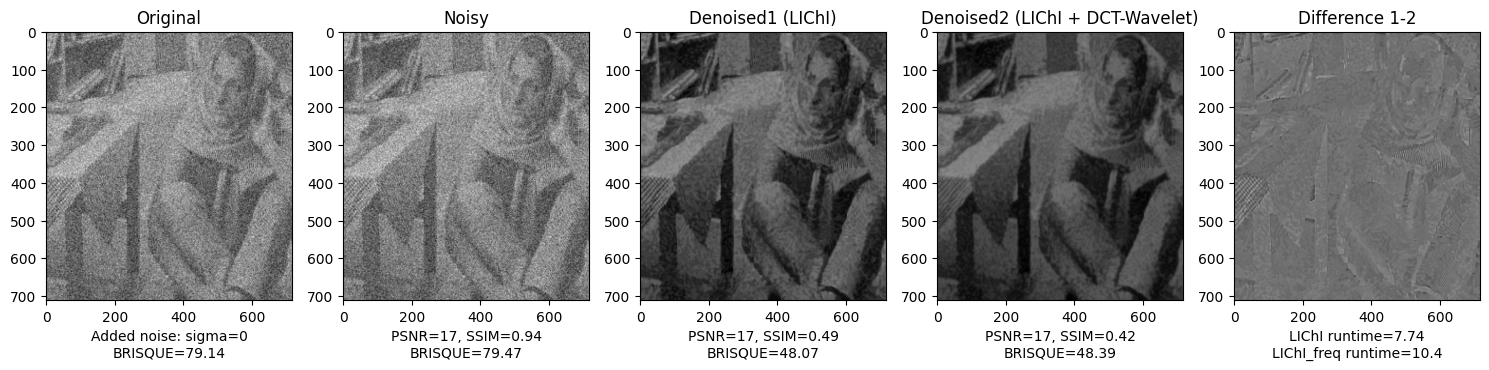

In [87]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./2.png', added_noise=0,noise_est_start=25) # set add to start where there's no PSD violation
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

28.557726588362044


<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


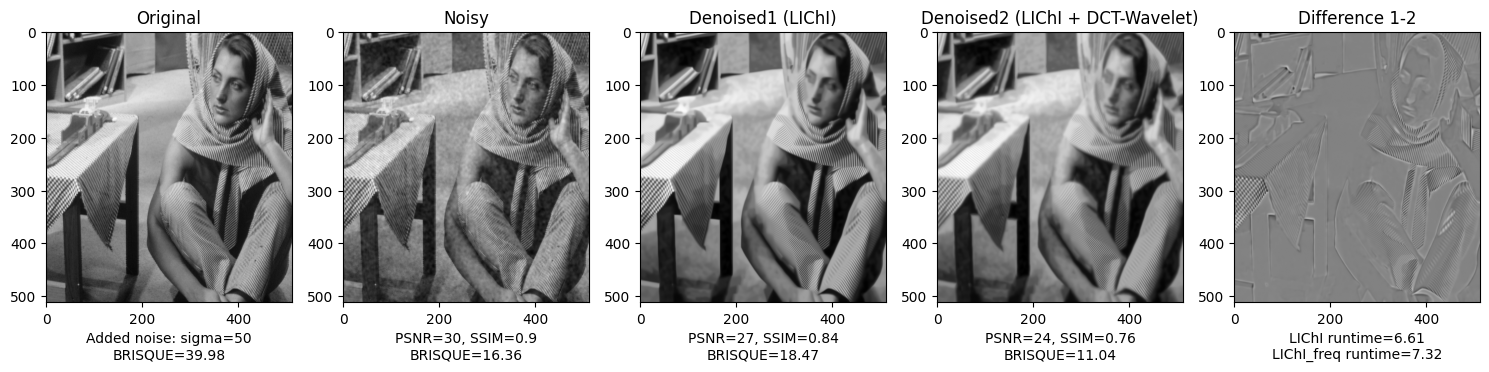

In [88]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./barbara.png', added_noise=50,structured=True,noise_est_start=20)
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

30.501480418717055


<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


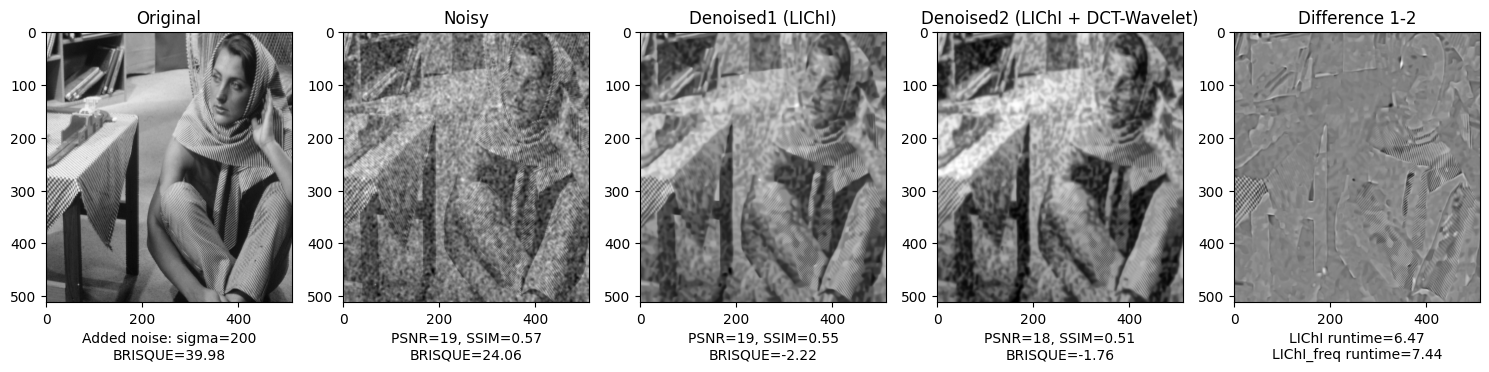

In [93]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./barbara.png', added_noise=200,structured=True,noise_est_start=10)
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

41.182026


<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


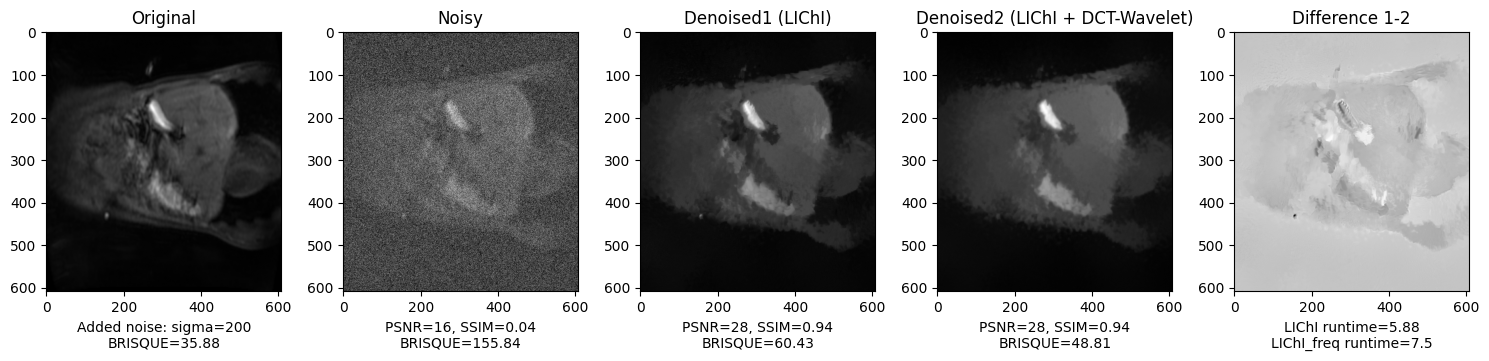

In [37]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./mri.png', added_noise=200)
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

17.483196


<ipython-input-33-7587a23c953c>:12: RuntimeWarning: divide by zero encountered in scalar divide
  psnrs = [10*np.log10(255**2 / np.mean((x - img_disp)**2)) for x in imgs]


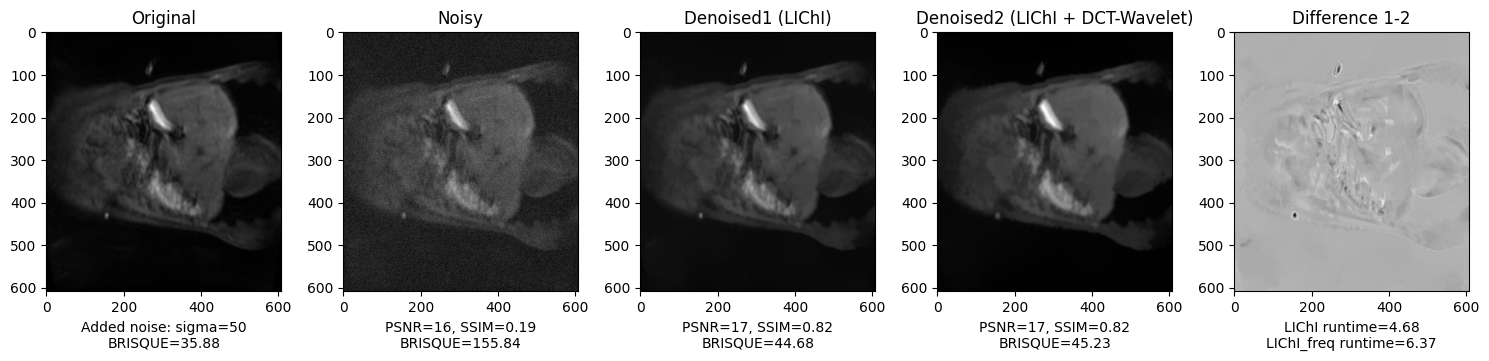

In [38]:
added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq=main(path_in='./mri.png', added_noise=50)
plot(added_noise,img,noisy_image,denoised,denoised_freq,elapsed,elapsed_freq)

## Testing Noise Estimation Methods (DCT thresholding)

In [91]:
"""
Frequency domain patch-based denoising
"""
import numpy as np
import cv2
import scipy

def dct_denoise_image(image, p=32, keep_fraction=0.95,threshold=None):
    """Denoise image via DCT thresholding with proper edge handling."""
    if keep_fraction==1:
        return image
    # Pad image to handle edges (mirror padding reduces boundary artifacts)
    pad_y = p - image.shape[0] % p
    pad_x = p - image.shape[1] % p
    image_padded = np.pad(image, ((0, pad_y), (0, pad_x)), mode='reflect')

    # Initialize output and weight matrices
    denoised = np.zeros_like(image_padded, dtype=float)
    weights = np.zeros_like(image_padded, dtype=float)

    # Process patches with 50% overlap
    s = 3
    for y in range(0, image_padded.shape[0] - p + 1, s):
        for x in range(0, image_padded.shape[1] - p + 1, s):
            # Extract patch
            patch = image_padded[y:y+p, x:x+p]
            # DCT + thresholding
            dct_patch = scipy.fftpack.dct(scipy.fftpack.dct(patch.T, norm='ortho').T, norm='ortho')
            # print(dct_patch)
            coeffs = np.sort(np.abs(dct_patch.ravel()))[::-1]
            if threshold is None:
              threshold = coeffs[int(len(coeffs) * keep_fraction)]
            dct_patch[np.abs(dct_patch) < threshold] = 0

            # Inverse DCT and accumulate
            denoised_patch = scipy.fftpack.idct(scipy.fftpack.idct(dct_patch.T, norm='ortho').T, norm='ortho')
            denoised[y:y+p, x:x+p] += denoised_patch
            weights[y:y+p, x:x+p] += 1

    # Normalize by weight counts and crop to original size
    denoised = denoised / weights
    return denoised[:image.shape[0], :image.shape[1]]

In [83]:
# import scipy
# mri=scipy.io.loadmat("./ratMRI.mat")['save_data']
# img=mri[:64,:64,10,0].T
from PIL import Image
import numpy as np

img = Image.open('mri2.png')
img = np.array(img).swapaxes(0,2)[:3].mean(axis=0,keepdims=True)
img = np.clip(img/255,0,1)

sigma=0.5
noisy_image = img + sigma * np.random.random(img.shape)
sig,sig_laplace=estimate_noise(img)
h,w=img.shape[-2:]
img=img[0]
noisy_image=noisy_image[0]

In [ ]:
# Example usage:
import matplotlib.pyplot as plt
thresholds=[0,sig,sig_laplace]
imgs=np.zeros((len(thresholds),h,w))
psnrs=[]
fig,axs=plt.subplots(1,len(thresholds)+2,figsize=(25,6))
axs[0].imshow(img,cmap='gray')
axs[0].set_title("Original")
axs[0].set_xlabel("PSNR=Inf DB")
axs[0].set_aspect(1.2)
for i in range(len(thresholds)):
    denoised=dct_denoise_image(noisy_image,threshold=thresholds[i])
    imgs[i]=denoised
    psnr = 10*np.log10(255**2 / np.mean((denoised - img)**2))
    psnrs.append(psnrs)
    axs[i+1].imshow(denoised,cmap='gray')
    axs[i+1].set_title(f"threshold={thresholds[i]:.2f}")
    axs[i+1].set_xlabel(f"PSNR={psnr:.2f} DB")
    axs[i+1].set_aspect(1.2)
axs[1].set_title("Noisy")
axs[-1].imshow(imgs[1:].mean(axis=0),cmap='gray')
axs[-1].set_aspect(1.2)
# levels=[0.01,0.02,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006,0.0000001]
# avgdenoise=im2
# for i in range(len(levels)):
#     _,x=dct_denoise_image(img,keep_fraction=levels[i])
#     avgdenoise+=x
# https://arxiv.org/pdf/1805.00472

## Frequency-based Patch Matching

In [ ]:
# only works for small images because of the unfolds
#TODO break down the loop. run referencing for each patch
import torch_dct as dct
# Calculate all possible DCT patches
dct_patches = rearrange(dct.dct_2d(F.unfold(input_x_pad, p, stride=1),norm="ortho"), 'n pp hw -> n hw pp')
print(dct_patches.shape)
# Norm of all DCT patches
norm_dct_patches = F.avg_pool1d(dct_patches**2,p*p)
print(norm_dct_patches.shape)
norm_dct_patches=rearrange(norm_dct_patches,"n (h w) 1 -> n 1 h w",h=H-p+1)
norm_dct_patches = F.unfold(norm_dct_patches, 2*v+1, stride=s)
norm_dct_patches=rearrange(norm_dct_patches,"n (h w) l -> n l h w",h=2*v+1)
print("norm size",norm_dct_patches.shape)
# All DCT patches
dct_patches = rearrange(dct_patches, 'n (h w) dct -> (n dct) 1 h w',h=H-p+1)
print("dct patches",dct_patches.shape) # n, N_X, N_Y, N_DCT_values=p*p
# All local windows
local_windows = F.unfold(dct_patches, 2*v+1, stride=s) / p
print("local window shape",local_windows.shape)
local_windows=rearrange(local_windows,'(n dct) (h w) l -> n l h w dct',h=2*v+1,dct=p*p)
ref_patches = rearrange(local_windows[..., v, v, :], 'n l (p1 p2) -> l n p1 p2',p1=p)
local_windows=rearrange(local_windows,'n l h w (p1 p2) -> (h w) (n l) p1 p2',p1=p)
print(local_windows.shape,ref_patches.shape) # 1 6 4 4 ; 6 1 2 2
scalar_product = F.conv2d(local_windows, ref_patches, groups=N*Href*Wref)
print(scalar_product.shape)
scalar_product=rearrange(scalar_product, '(h w) l n 1 -> n l h w',h=2*v+1)
print(scalar_product.shape)
distances = norm_dct_patches - 2 * scalar_product # (up to a constant)
distances[:, :, v, v] = float('-inf') # the reference patch is always taken
distances = rearrange(distances, '1 (n h w) p1 p2 -> n h w (p1 p2)', n=N, h=Href, w=Wref)
print(distances.shape)
indices = torch.topk(alpha*distances, k, dim=3, largest=False, sorted=False).indices # float('nan') is considered to be the highest value for topk
print(indices)

https://arxiv.org/pdf/1805.00472